In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BDT packages
import xgboost as xgb
import lightgbm as lgb
import json

In [76]:
### Set default plot parameters

# Font and fontsize
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Grid
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.grid'] = True

# Background color
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'gainsboro'
plt.rcParams['savefig.facecolor'] = 'white'

# Legend background color
plt.rcParams['legend.facecolor'] = 'white'

___

# Applied Machine Learning 2024: *Initial Project*
#### *Niels August Daivdsen (phx657)*
___

## Second part: Making regression to estimate the energy of electrons in dataset 1


In [77]:
# Importing the top 12 variables
sort_variables_pi = pd.read_csv('handins/Regression_NielsDavidsen_LightGBMreg_VariableList.csv', header=None)
sort_variables_pi = sort_variables_pi[0].tolist()


# Load the data
data = pd.read_csv("AppML_InitialProject_train.csv", sep=",")

# Slicing the data for only electrons
input_data = data[data['p_Truth_isElectron'] == 1]
energy_data = input_data['p_Truth_Energy']
input_data = input_data.drop(columns=['p_Truth_isElectron', 'p_Truth_Energy'])
variables = input_data.columns.tolist()

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(input_data, energy_data, test_size=0.2, random_state=42)


### LightGBM regression on top 12 varaibles

In [78]:
# Defining basic parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 20,
    'num_leaves': 30,
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'n_estimators': 1000,
    'verbose': -1,
    'early_stopping_rounds': 20
}

RMSE: 17601.758
MAE: 8419.886
MSE: 309821872.569


Text(0.5, 1.0, 'LGBM Regression Model with Top 12 Features')

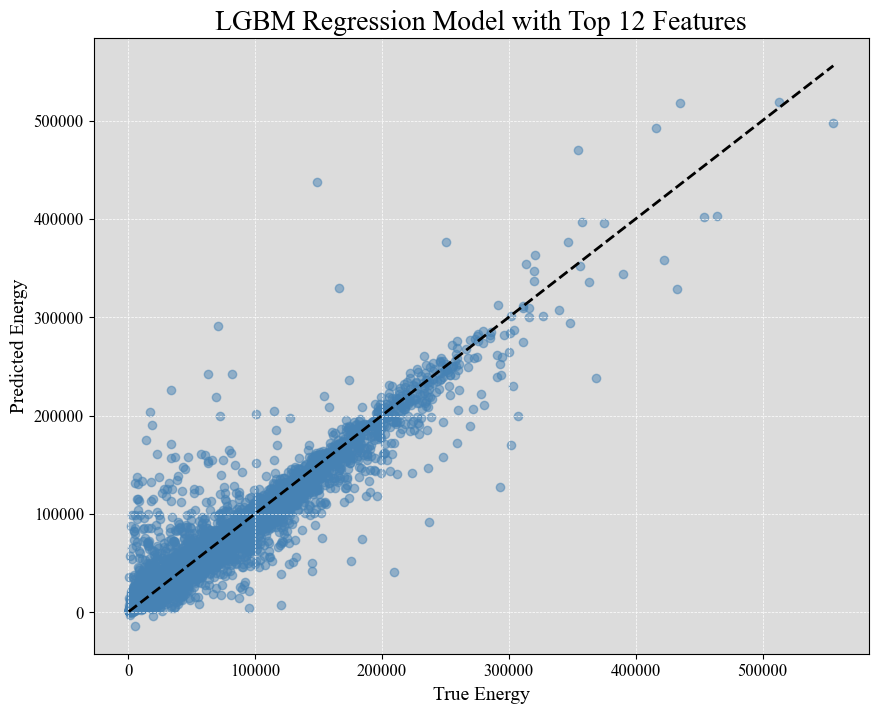

In [79]:
# LightGBM regression model with top 12 features
data_top12s = input_data[sort_variables_pi]
X_train, X_valid, y_train, y_valid = train_test_split(data_top12s, energy_data, test_size=0.2, random_state=42)

reg_model_top12s = lgb.LGBMRegressor(**params)
model_fit_top12s = reg_model_top12s.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

# Evalutating the model
y_pred = model_fit_top12s.predict(X_valid)

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")

# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(y_valid, y_pred, alpha=0.5, color='steelblue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("True Energy")
plt.ylabel("Predicted Energy")
plt.title("LGBM Regression Model with Top 12 Features")


In [80]:
# Optuna HPO
import optuna

def objective(trial):
    params = {
        'obejctive': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'verbose': -1,
        'early_stopping_rounds': 20
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    y_pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred)
    return rmse

### Run for optimized hyperparameters (if needed) ### 

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)
# trial = study.best_trial
# 
# 
# # save the best hyperparameters
# best_params = trial.params
# best_params['objective'] = 'regression'
# best_params['boosting_type'] = 'gbdt'
# best_params['metric'] = 'rmse'
# best_params['verbose'] = -1
# best_params['early_stopping_rounds'] = 20
# 
# # Save them in a file
# with open('reg_best_params.json', 'w') as f:
#     json.dump(best_params, f)
#     f.close()

{'num_leaves': 53, 'max_depth': 36, 'learning_rate': 0.04048383383512557, 'min_data_in_leaf': 26, 'n_estimators': 494, 'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'verbose': -1, 'early_stopping_rounds': 20}
Optimized RMSE: 17380.501
Optimized MAE: 0.299
Optimized MSE: 302081805.402


Text(0.5, 1.0, 'LGBM Regression Model with Optimized Hyperparameters')

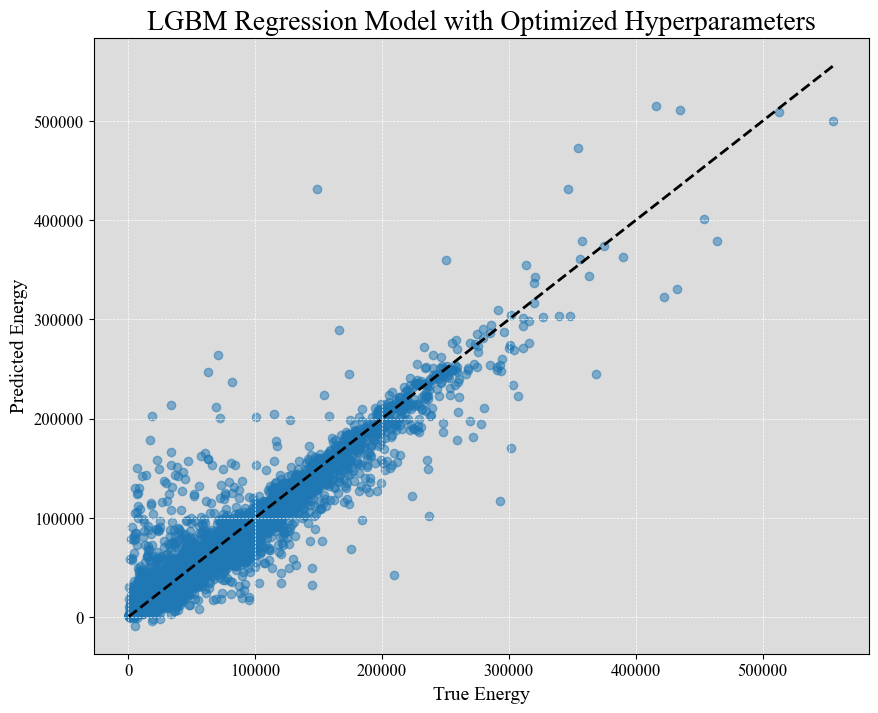

In [81]:
# Load the best hyperparameters
with open('reg_best_params.json', 'r') as f:
    opt_params = json.load(f)
    f.close()
print(opt_params)


# Retrain the model with the optimized parameters
reg_model_opt = lgb.LGBMRegressor(**opt_params)
model_opt = reg_model_opt.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
y_pred_opt = model_opt.predict(X_valid)


mse_opt = mean_squared_error(y_valid, y_pred_opt)
mae_opt = np.mean(np.abs(y_pred_opt - y_valid)/y_valid)
rmse_opt = np.sqrt(mse_opt)

print(f"Optimized RMSE: {rmse_opt:.3f}")
print(f"Optimized MAE: {mae_opt:.3f}")
print(f"Optimized MSE: {mse_opt:.3f}")
# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(y_valid, y_pred_opt, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("True Energy")
plt.ylabel("Predicted Energy")
plt.title("LGBM Regression Model with Optimized Hyperparameters")


### Trying the optimized LGBM model on the test data



In [82]:
# Loadng the test data
test_data = pd.read_csv("AppMl_InitialProject_test_regression.csv", sep=",")

# Using top 12 features
test_data_top12s = test_data[sort_variables_pi]

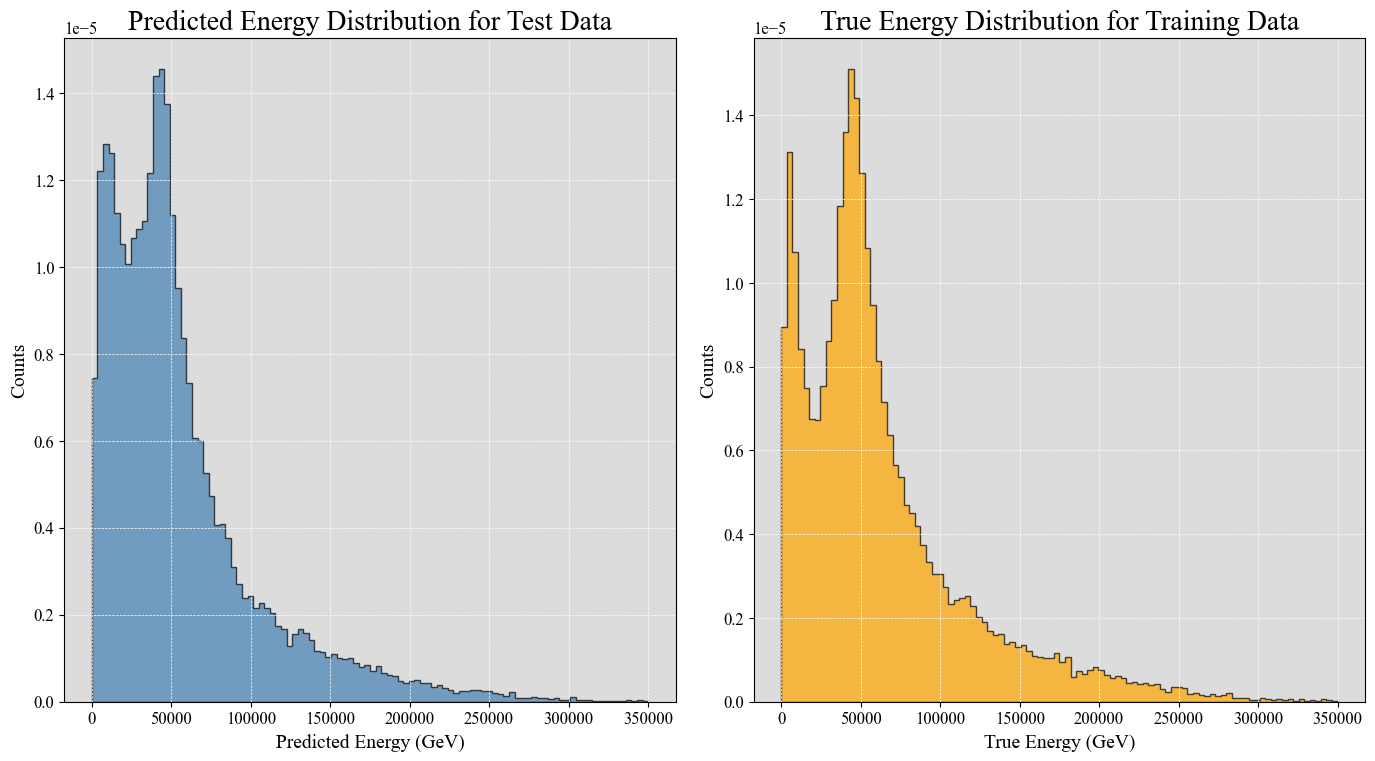

In [83]:
# Predicting the energy of the test data
y_test_pred = model_opt.predict(test_data_top12s)
hist_range=(0, 350000)

fig, ax = plt.subplots(1,2,figsize=(14, 8))
ax[0].hist(y_test_pred, bins=100, color='steelblue', alpha=0.7, edgecolor='black', histtype='stepfilled', density=True, range=hist_range);
ax[0].set_xlabel("Predicted Energy (GeV)")
ax[0].set_ylabel("Counts")
ax[0].set_title("Predicted Energy Distribution for Test Data")

ax[1].hist(energy_data, bins=100, color='orange', alpha=0.7, edgecolor='black', histtype='stepfilled', density=True, range=hist_range);
ax[1].set_xlabel("True Energy (GeV)")
ax[1].set_ylabel("Counts")
ax[1].set_title("True Energy Distribution for Training Data")
plt.tight_layout()


In [66]:
# Save the test_predictions
pd.Series(y_test_pred).to_csv('handins/Regression_NielsDavidsen_LightGBMreg.csv', index=True, header=None)

### Regression Neural Network using PyTorch


In [67]:
# Using LightGBM feature importance
lgbm_features = pd.read_csv('handins/Regression_NielsDavidsen_TorchNNreg_VariableList.csv', header=None)
lgbm_features = lgbm_features[0].tolist()

# Reloading the data
lgbm_top12_input = input_data[lgbm_features]
X_train, X_valid, y_train, y_valid = train_test_split(lgbm_top12_input, energy_data, test_size=0.2, random_state=42)
lgbm_top12_test = test_data[lgbm_features]


In [68]:
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)


In [69]:
# Defining the neural network model
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

class RegressionDataset(Dataset):
    def __init__(self, X, y=None):
        
        if isinstance(X, pd.Series):
            X = X.values.reshape(-1, 1)  # Make it 2D
        if isinstance(X, pd.DataFrame):
            X = X.values
        X = np.asarray(X, dtype=np.float32)
        self.X = torch.from_numpy(X)
        if y is not None:
            if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
                y = y.values
            y = np.asarray(y, dtype=np.float32).reshape(-1, 1)  # Make it 2D
            self.y = torch.from_numpy(y)
        else:
            self.y = None

    def __len__(self):
        value = int(len(self.X))
        return value
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]
        
class SimpleRegressionNN(nn.Module):
    # No dropout implemented
    def __init__(self, input_size):
        super(SimpleRegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)        # Hidden layer 1
        self.fc2 = nn.Linear(64, 32)                # Hidden layer 2    
        self.fc3 = nn.Linear(32, 1)                 # Output layer (1 neuron for findng the energy)

    def forward(self, x):
        x = F.relu(self.fc1(x))                     # ReLU activation function
        x = F.relu(self.fc2(x))                     # ReLU activation function
        x = self.fc3(x)
        return x
    
# Training and evaluation functions
def train_reg_NN(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    return running_loss / len(loader.dataset)

def evaluate_reg_NN(model, loader, criterion, device, ynone=False):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        if ynone:
            for x_batch in loader:
                x_batch = x_batch.to(device)
                outputs = model(x_batch)
                all_preds.append(outputs.cpu().numpy())
            preds = np.concatenate(all_preds)
            targets = None

        else:
            for x_batch, y_batch in loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * x_batch.size(0)
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(y_batch.cpu().numpy())

            preds = np.concatenate(all_preds)
            targets = np.concatenate(all_targets)
  
    return running_loss / len(loader.dataset), preds, targets



In [70]:
# Creating PyTorch datasets and dataloaders
train_dataset = RegressionDataset(X_train_scaled, y_train)
valid_dataset = RegressionDataset(X_valid_scaled, y_valid)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


In [74]:
from sklearn.metrics import roc_auc_score, roc_curve

# Initializing the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleRegressionNN(input_size=X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Setting up the training parameters
n_epochs = 1000
train_losses = []
valid_losses = []
rmse = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 10
counter = 0
epoch_reached = 1
best_model_state = None
mae_list = []
# Training loop
for epoch in range(n_epochs):
    train_loss = train_reg_NN(model, train_loader, criterion, optimizer, device)
    valid_loss, preds, targets = evaluate_reg_NN(model, valid_loader, criterion, device)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    rmse.append(np.sqrt(valid_loss))
    mae = np.mean(np.abs(preds - targets)/targets)

    # Early stopping
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            epoch_reached = epoch + 1
            print(f"MAE at early stopping: {mae:.4f}")
            break

    epoch_reached = epoch + 1

    if epoch % 100 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, MAE: {mae:.4f}")


Epoch 1/1000, Train Loss: 7165914899.7757, Valid Loss: 6774383610.3111, MAE: 0.9634
Epoch 101/1000, Train Loss: 513209233.2698, Valid Loss: 506916611.5217, MAE: 0.4788
Epoch 201/1000, Train Loss: 452086085.4688, Valid Loss: 452263965.7312, MAE: 0.4599
Epoch 301/1000, Train Loss: 394075708.2667, Valid Loss: 405213239.6698, MAE: 0.4628
Epoch 401/1000, Train Loss: 370606870.2138, Valid Loss: 383677693.7651, MAE: 0.4457
Early stopping at epoch 402
MAE at early stopping: 0.4501


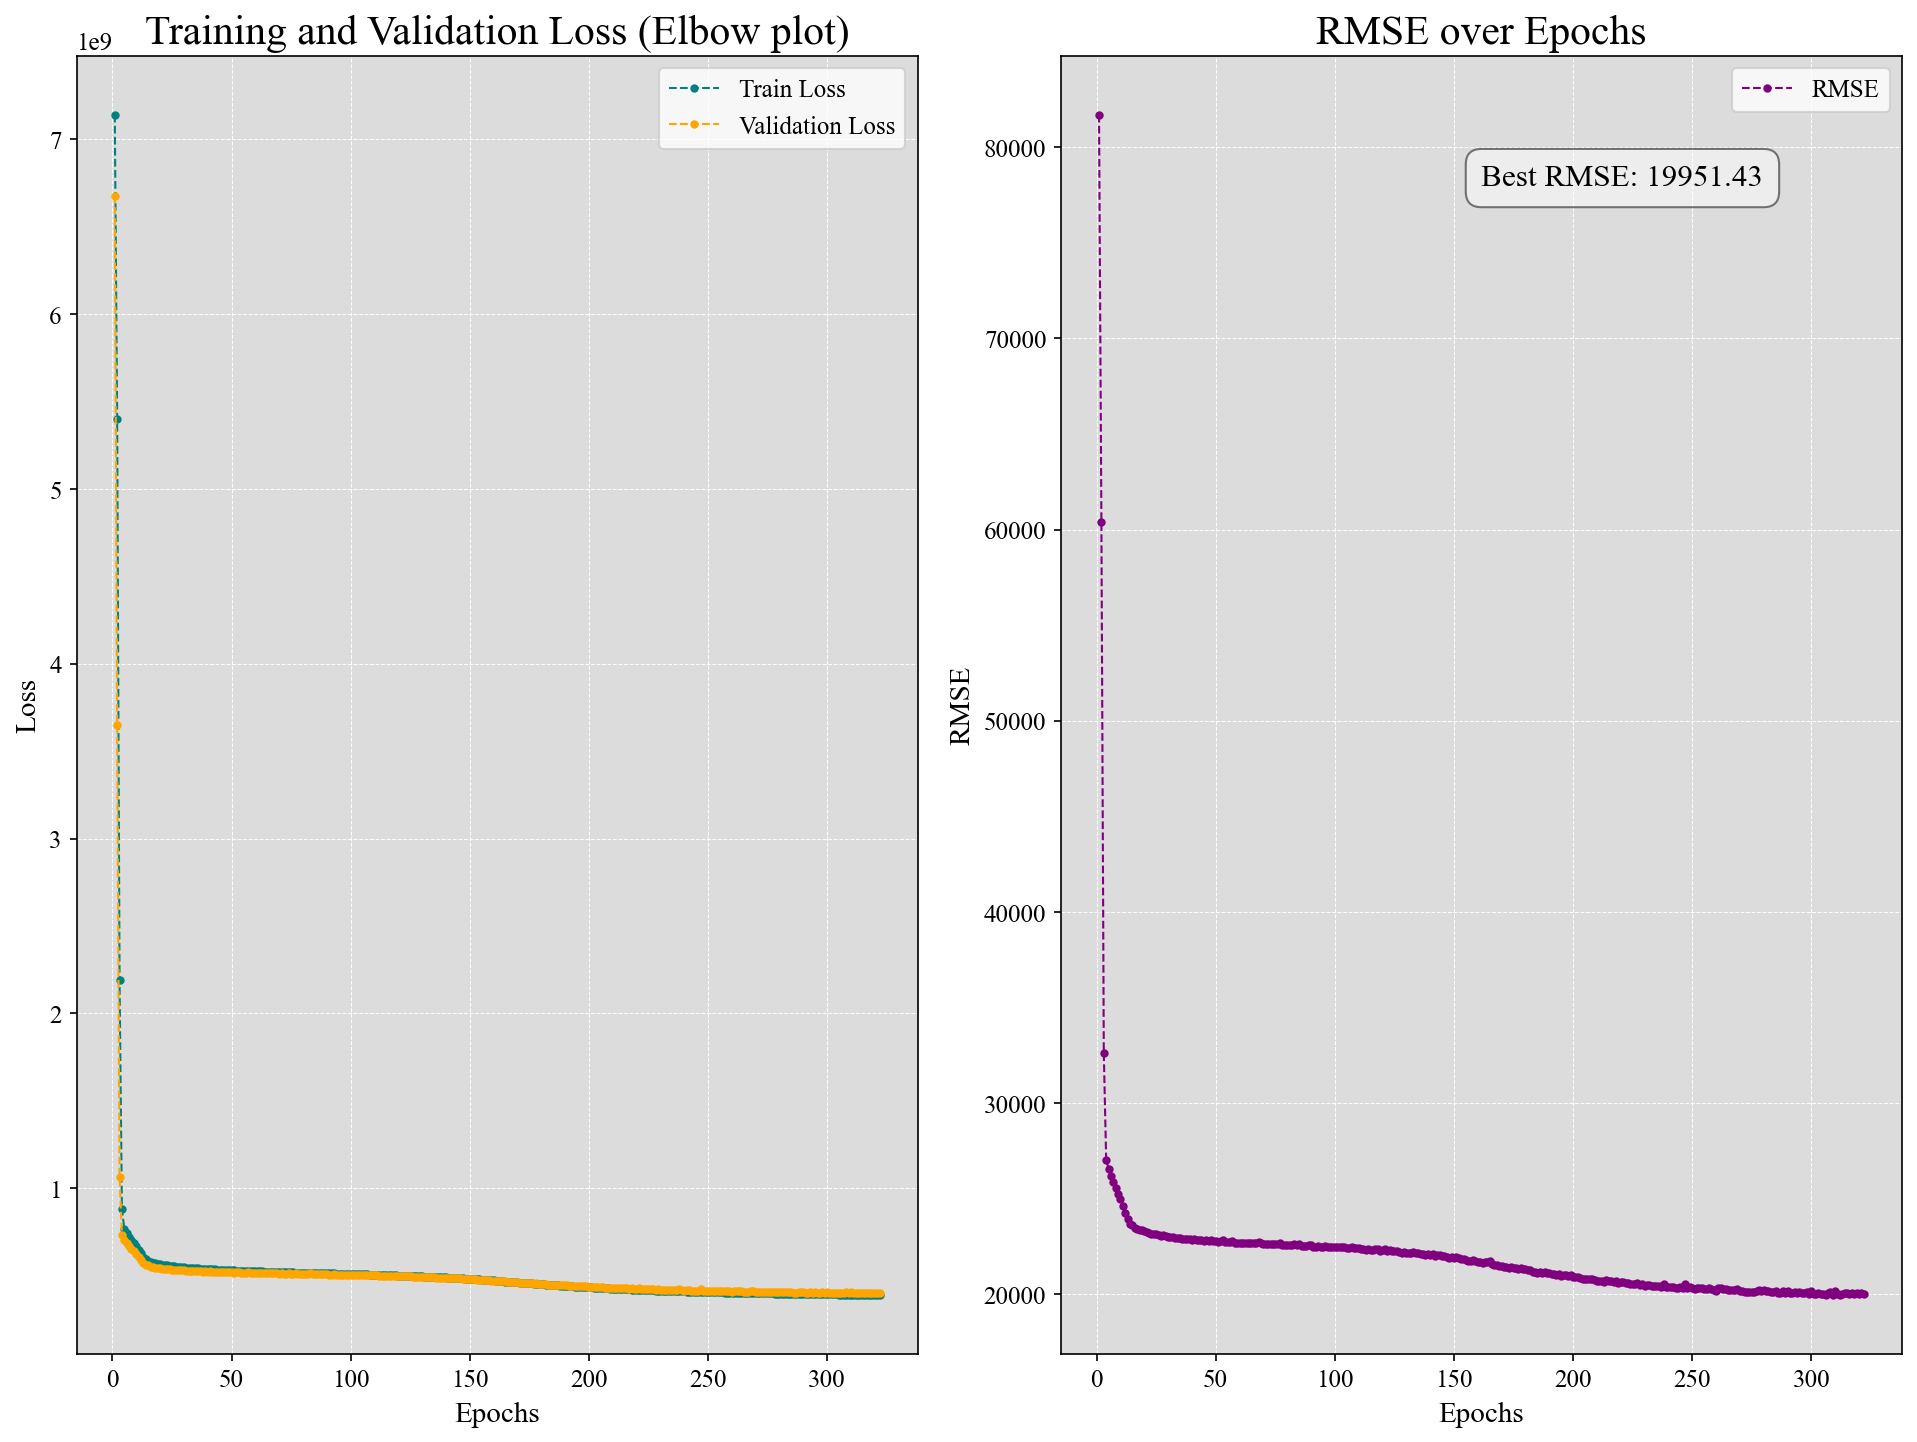

In [72]:
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(1,2,figsize=(13, 10), dpi=150, facecolor="white")
ax[0].plot(range(1, epoch_reached + 1), train_losses, label="Train Loss", color="teal", marker='.', ls='--', linewidth=1)
ax[0].plot(range(1, epoch_reached + 1), valid_losses, label="Validation Loss", color="orange", marker='.', ls='--', linewidth=1)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training and Validation Loss (Elbow plot)")
ax[0].legend()


best_rmse = min(rmse)

ax[1].plot(range(1, epoch_reached + 1), rmse, label="RMSE", color="purple", marker='.', ls='--', linewidth=1)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("RMSE")
ax[1].set_title("RMSE over Epochs")
ax[1].legend()
ax[1].text(0.5, 0.9, 
           f"Best RMSE: {best_rmse:.2f}", 
           transform=ax[1].transAxes, 
           fontsize=15, 
           bbox=dict(facecolor='white', alpha=0.5, boxstyle="round,pad=0.5"))
plt.tight_layout()

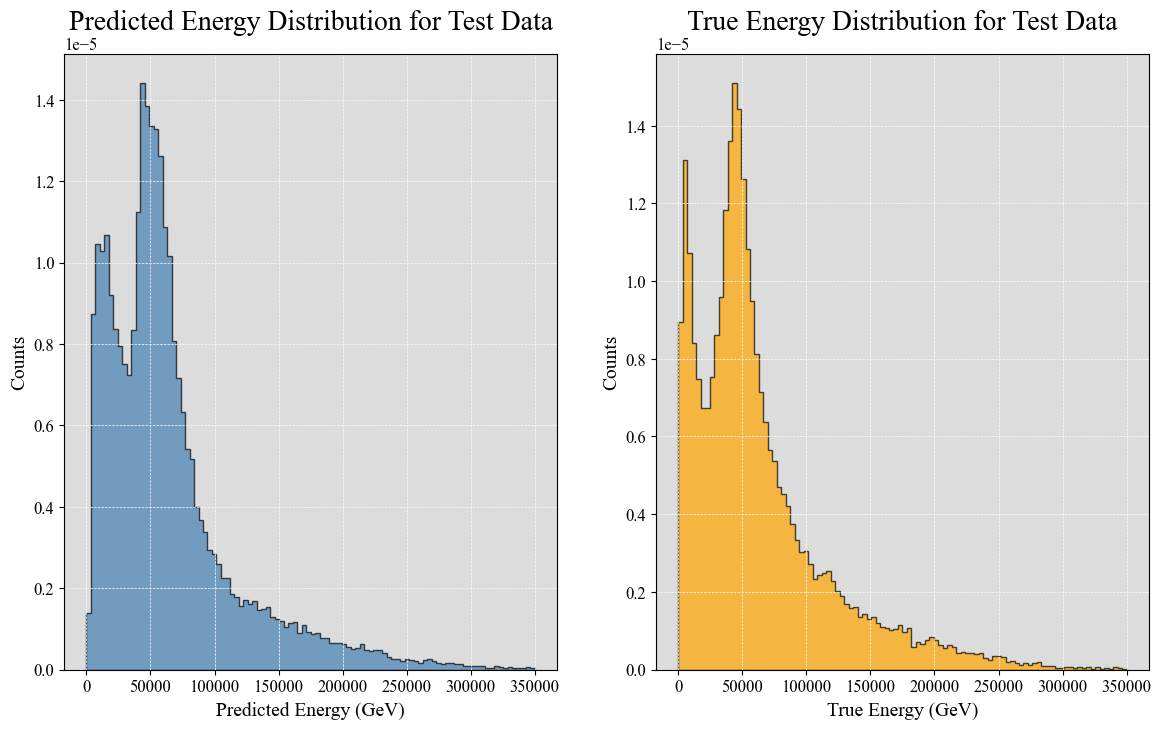

In [73]:
# Using the model to predict the test data
test_data_scaled = pd.DataFrame(scaler.fit_transform(lgbm_top12_test), columns=lgbm_top12_test.columns)
test_dataset = RegressionDataset(test_data_scaled)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluating the model on the test data
model.load_state_dict(best_model_state)
test_loss, test_preds, test_targets = evaluate_reg_NN(model, test_loader, criterion, device, ynone=True)

fig, ax = plt.subplots(1,2,figsize=(14, 8))
ax[0].hist(test_preds, bins=100, color='steelblue', alpha=0.7, edgecolor='black', histtype='stepfilled', density=True, range=hist_range);
ax[0].set_xlabel("Predicted Energy (GeV)")
ax[0].set_ylabel("Counts")
ax[0].set_title("Predicted Energy Distribution for Test Data")

ax[1].hist(energy_data , bins=100, color='orange', alpha=0.7, edgecolor='black', histtype='stepfilled', density=True, range=hist_range);
ax[1].set_xlabel("True Energy (GeV)")
ax[1].set_ylabel("Counts")
ax[1].set_title("True Energy Distribution for Test Data")


pd.Series(test_preds[:,0]).to_csv('handins/Regression_NielsDavidsen_TorchNNreg.csv', index=True, header=None)
